In [1]:
import sys
import os
import numpy as np
import pandas as pd
import random
import re
np.set_printoptions(threshold=sys.maxsize) # to display the entire array

# Geospatial Pkgs 
import xarray as xr
import gdal
from affine import Affine
from gdalconst import *
from osgeo import osr
import shapefile as sh
import geopandas as gpd
import fiona
import shapely
from shapely.geometry import shape, box, LineString, MultiPolygon, Polygon, MultiPoint, Point, LinearRing
from shapely import wkt
from shapely.wkt import loads
from shapely.ops import unary_union
from wktplot import WKTPlot
from wktplot.plots.osm import OpenStreetMapsPlot #### Import OpenStreetMaps plotting class

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook
# from IPython.display import Image
# output_notebook()

from platform import python_version
print(f"Py version {python_version()}")
print(f"Shapely version {shapely.__version__}")
print(f"Shapely GEOS version {shapely.geos_version_string}")
print(f"Shapely GEOS C API version {shapely.geos_capi_version_string}")

# Rasdaman
from rasdapy.db_connector import DBConnector
from rasdapy.query_executor import QueryExecutor

db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
query_executor = QueryExecutor(db_connector)
db_connector.open() # connection open

if db_connector is not None:
    print("RasDaMan is running") 
    
def restart_rasdaman():
    from rasdapy.db_connector import DBConnector
    from rasdapy.query_executor import QueryExecutor

    db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
    query_executor = QueryExecutor(db_connector)
    db_connector.open() # connection open

Py version 3.8.10
Shapely version 2.0.1
Shapely GEOS version 3.11.1
Shapely GEOS C API version 3.11.1-CAPI-1.17.1
RasDaMan is running


In [2]:
def grid2WKT_polygon(long_array, lat_array):
    """Create the polygon geometry with requires at least 2 pairs of long, lat coordinates."""
    polygon = Polygon(zip(long_array, lat_array))
    return polygon.wkt

def grid2WKT_ring(long_array, lat_array):
    """Create the linearring geometry with requires at least 2 pairs of long, lat coordinates."""
#     coordinates = list(zip(long_array, lat_array))
#     ring_wkt = "LINEARRING(" + ", ".join(f"{x} {y}" for x, y in coordinates) + ")"
    ring_wkt = LinearRing(zip(long_array, lat_array))
    return ring_wkt
  
def geo2grid(lons, lats, xmin, ymax, pixel_size, xskew = 0.0, yskew = 0.0):
    """ Translate geo indices to grid indices """
    # Geotransform object
    aff_gdal = Affine.from_gdal(xmin, pixel_size, xskew, ymax, yskew, -pixel_size)
    # coordinate data
    lons = np.array(lons)
    lats = np.array(lats)
    xs, ys = ~aff_gdal*(lons, lats)
    xs = np.int64(xs)
    ys = np.int64(ys)

    return xs, ys 

def add_closing_coordinates(d):
    d = str(d)
    """ Adds the first 'lat long' to the end"""
    i = re.search(r"\d", d).start()
    j = re.search(r'(\d)[^\d]*$', d).start() + 1
    c = d.index(',')    
    return d[:j] + ", " + d[i:c] + d[j:]

def processRING(ring):
    lat_arr = []
    long_arr = []
    if ring.is_closed == True:
        # Extract longitudes and latitudes
        longitudes, latitudes = zip(ring.xy)
        
        for i in range(len(latitudes[0])):
            long_arr = np.append(long_arr, longitudes[0][i])
            lat_arr = np.append(lat_arr, latitudes[0][i])

        long_list = long_arr.tolist()
        lat_list = lat_arr.tolist()

        x_grid, y_grid = geo2grid(long_list, lat_list, xmin, ymax, pixel_size)
        gridRING_yx = grid2WKT_ring(y_grid, x_grid)

        return gridRING_yx
    else:
        print("Incomplete ring")

        
def processPOLYGON(inputPOLYGON, regionID = None):
    if len(inputPOLYGON.interiors) == 0:
        polygon = wkt.loads(add_closing_coordinates(inputPOLYGON))
        coords = np.dstack(polygon.boundary.xy).tolist()[0][:-1]
        expected_list_of_coordinates_for_received_code = [{"long": x, "lat": y} for x, y in coords]
        lat_arr = []
        long_arr = []
        for i in range(len(expected_list_of_coordinates_for_received_code)):
            long_arr = np.append(long_arr, expected_list_of_coordinates_for_received_code[i]['long'])
            lat_arr = np.append(lat_arr, expected_list_of_coordinates_for_received_code[i]['lat'])

        long_list = long_arr.tolist()
        lat_list = lat_arr.tolist()

        x_grid, y_grid = geo2grid(long_list, lat_list, xmin, ymax, pixel_size)
        gridPOLYGON_yx = grid2WKT_polygon(y_grid, x_grid)

        return gridPOLYGON_yx
    else:
        print(f"{regionID}: \x1b[1;31m{len(inputPOLYGON.interiors)}\x1b[0m Polygon Rings Detected")
        mainPOLYGON = Polygon(inputPOLYGON.exterior)  # Convert main ring to main polygon without inner ring
        gridPOLYGON_yx = wkt.loads(processPOLYGON(mainPOLYGON))
        
        linear_rings_array = []

        for ring in range(len(inputPOLYGON.interiors)):
            gridRING = processRING(inputPOLYGON.interiors[ring])
            linear_rings_array.append(gridRING)
            
        gridPOLYGON_WITH_HOLE_yx = Polygon(gridPOLYGON_yx.exterior, linear_rings_array)
        print(f"{regionID}: \x1b[1;31m{len(inputPOLYGON.interiors)}\x1b[0m Polygons are Processed")
        
        return gridPOLYGON_WITH_HOLE_yx #return gridPOLYGON_yx_assembled
    
        

######## Mother Function ##############################################################################################
########################################################################################

def geoPOLYGON_to_gridPOLYGON_03(inputREGION, regionID = None):
    polygons_array1 = []
    polygons_array2 = []
    i = 0
    r = 0
    if inputREGION.geom_type == 'Polygon':
        print(f"{regionID}: Polygon is processing")
        return processPOLYGON(inputREGION, regionID)
    
    elif len(list(inputREGION.geoms[0].interiors)) > 0:    # MultiPolygon with atleast 1 inner rings
        print(f"{regionID}: MultiPolygon has Inner Rings")        
        for polygon in inputREGION.geoms:
            gridPOLYGON = processPOLYGON(polygon)
            polygons_array1.append(gridPOLYGON)
            r = r +1
            
        gridMULTI =  [wkt.loads(poly) for poly in polygons_array1]
        return shapely.geometry.MultiPolygon(gridMULTI)

    else:                                                  # MultiPolygon with 0 rings
        print(f"{regionID}: MultiPolygon is processing")
        for polygon in inputREGION.geoms:
            gridPOLYGON = processPOLYGON(polygon)
            polygons_array2.append(gridPOLYGON)
            i = i +1
            #print(f"flag {i}") # i th inner polygon
            
        gridMULTI =  [wkt.loads(poly) for poly in polygons_array2]
        return shapely.geometry.MultiPolygon(unary_union(gridMULTI))
#       return shapely.geometry.MultiPolygon(gridMULTI)
#       return MultiPolygon([polygons_array2])

######## GIS F(X) ##############################################################################################
################################################################################################################


def query2numeric(query):
    result = query_executor.execute_read(query) 
    return float("{}".format(result))

def query2result(query):
    result = query_executor.execute_read(query) 
    print(result)
    print(type(result))
    return result

def query2array2visuallize(query, title=None, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
        data = numpy_array
    else:
        # Data for the heat map
        data = numpy_array
    # Function to show the heat map
    ax = sns.heatmap( data , cmap = 'Spectral_r')
    # Adding details to the plot
    plt.rcParams["figure.figsize"]=(7,5)
    plt.title(title)
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    # Displaying the plot
    plt.show()
    return True #return numpy_array  


def vizVectorGeom(input_geom):
#     geojson = {'type': 'Polygon', 'coordinates': [[[34, 31], [32, 31], [34, 33]]]}
    gdf = gpd.GeoDataFrame({'geometry':[shape(input_geom)]}, crs='EPSG:4326')
    ax = gdf.plot(facecolor='#80a4ff33', edgecolor='red', linewidth=1)
    cx.add_basemap(ax=ax, crs='EPSG:4326', source=cx.providers.OpenStreetMap.Mapnik, zoom=10)
    plt.show()
    print(input_geom.geom_type)

In [3]:
gdfBAV = gpd.read_file('/home/arkaghosh/Downloads/Bavaria/Vector/Baveria_1.shp')
gdfSWE = gpd.read_file('/home/arkaghosh/Downloads/rasdapy3_dir/SWE_adm/SWE_adm2.shp')
gdfTYR = gpd.read_file('/home/arkaghosh/Downloads/Bolzano/Vector/South_Tyrol_LOD3.shp') 

In [4]:
raster01_path = '/home/arkaghosh/Downloads/Bavaria/Raster/Baveria_Temp_MOD11A1.061_1km_aid0001.nc'
raster02_path = '/home/arkaghosh/Downloads/RASDAMAN_FINALE/Worked/Sweden/Temperature_1km.nc'
raster03_path = '/home/arkaghosh/Downloads/Bolzano/Raster/Bolzano_Temp_MOD11A1.061_1km_aid0001.nc'

In [ ]:
f = xr.open_dataset(raster02_path)
lons = f['lon'].values
lats = f['lat'].values
lst_var = f['LST_Night_1km'].values

In [240]:
xmax = float(f['lon'].max())
xmin = float(f['lon'].min())

ymin = float(f['lat'].min())
ymax = float(f['lat'].max())

In [241]:
xmin, xmax

(10.962499999017922, 24.170833331167984)

In [242]:
ymin, ymax

(55.33749999504258, 69.06249999381302)

In [243]:
pixel_size = 0.00833333333258679

### Sjöbo (II)

Sjöbo


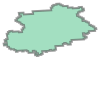

In [54]:
gid = 147 #246, 9, 150 || 214 (Umeå)
print(gdfSWE.NAME_2[gid])
INPUT = gdfSWE.geometry[gid]
INPUT

In [55]:
INPUT.geom_type, type(INPUT)

('Polygon', shapely.geometry.polygon.Polygon)

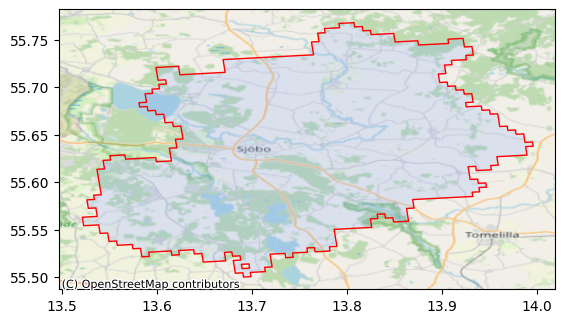

Polygon


In [57]:
vizVectorGeom(INPUT)

In [10]:
# qAGGREGATE= 'select avg_cells(clip((m[145, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT)) + ')) from Surface_Temperature_Sweden as m'
# query2numeric(qAGGREGATE)

In [58]:
INPUT.interiors[:]

[<LINEARRING (13.697 55.51, 13.696 55.514, 13.688 55.514, 13.689 55.51, 13.69...>]

In [59]:
INPUT.area

0.07251093255763381

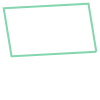

In [60]:
INPUT.interiors[0]

In [25]:
INPUT.interiors[0].area

0.0

In [48]:
print(INPUT.interiors[0])

LINEARRING (13.697088241577092 55.51000595092779, 13.696358680725211 55.51448059082031, 13.688464164733887 55.514057159423885, 13.689192771911678 55.50958251953131, 13.697088241577092 55.51000595092779)


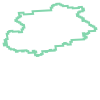

In [38]:
INPUT.exterior

In [39]:
INPUT.exterior.area

0.0

In [49]:
print(INPUT.exterior)

LINEARRING (13.66404819488531 55.5172576904298, 13.656149864196777 55.516830444335994, 13.64825630187994 55.516407012939396, 13.647521972656364 55.52087783813482, 13.646787643432617 55.525352478027344, 13.638888359069824 55.524925231933594, 13.638154029846248 55.52939987182617, 13.630254745483455 55.528972625732536, 13.622358322143555 55.52854537963873, 13.623096466064453 55.52407073974615, 13.615199089050236 55.5236434936524, 13.614458084106445 55.52811431884777, 13.606562614441032 55.52768707275396, 13.598666191101074 55.527256011963004, 13.590768814086914 55.5268287658692, 13.591509819030875 55.52235412597662, 13.583612442016658 55.52192306518566, 13.582872390747127 55.52639770507824, 13.582128524780273 55.53086853027344, 13.574231147766056 55.53043746948248, 13.57348823547369 55.53491210937506, 13.565588951110897 55.5344810485841, 13.55769157409668 55.53404998779291, 13.55694675445568 55.53852081298834, 13.549047470092887 55.53808975219732, 13.5483016967774 55.54256057739258, 13.54

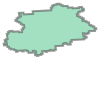

In [45]:
main = Polygon(INPUT.exterior)
main

In [46]:
main.area

0.07254656852455757

### Traunstein

Traunstein


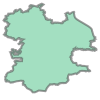

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/rasdapy/cores/utils.py", line 447, in run
    self._target(*self._args)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/rasdapy/cores/remote_procedures.py", line 73, in rasmgr_keep_alive
    return stub.KeepAlive(make_rasmgr_keep_alive_req(cuuid), _TIMEOUT_SECONDS)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/grpc/_channel.py", line 946, in __call__
    return _end_unary_response_blocking(state, call, False, None)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/grpc/_channel.py", line 849, in _end_unary_response_blocking
    raise _InactiveRpcError(state)
grpc._channel._InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "NThe client with client ID 25 does not exist: cannot reset client's 

In [72]:
gid = 88 #76 || 214 (Umeå)
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

In [63]:
INPUT.interiors[:]

[<LINEARRING (12.418 47.868, 12.418 47.869, 12.418 47.869, 12.418 47.869, 12....>,
 <LINEARRING (12.41 47.861, 12.408 47.862, 12.407 47.863, 12.407 47.863, 12.4...>,
 <LINEARRING (12.424 47.873, 12.424 47.873, 12.424 47.873, 12.424 47.873, 12....>,
 <LINEARRING (12.752 47.886, 12.752 47.886, 12.752 47.886, 12.753 47.887, 12....>]

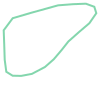

In [66]:
INPUT.interiors[0]

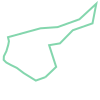

In [67]:
INPUT.interiors[3]

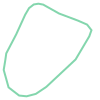

In [68]:
INPUT.interiors[2]

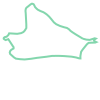

In [70]:
INPUT.interiors[1]

### Göteborg (IV)

Göteborg


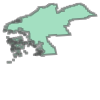

In [285]:
gid = 246 #246, 9, 150 || 214 (Umeå)
print(gdfSWE.NAME_2[gid])
INPUT = gdfSWE.geometry[gid]
INPUT

In [286]:
len(list(INPUT.geoms[2].interiors)) 

0

In [288]:
len(INPUT.geoms[2].interiors)

0

In [6]:
INPUT.geom_type, type(INPUT)

('MultiPolygon', shapely.geometry.multipolygon.MultiPolygon)

In [7]:
print(INPUT)

MULTIPOLYGON (((12.093682289123535 57.67838287353521, 12.094663619995174 57.6739234924317, 12.086322784423828 57.67339324951172, 12.077977180480957 57.67285919189459, 12.069632530212402 57.6723251342774, 12.061288833618164 57.67179107666027, 12.052947044372672 57.67125320434576, 12.044603347778434 57.67071914672863, 12.036261558532715 57.67018127441412, 12.027917861938477 57.66964721679693, 12.019576072692985 57.66910934448242, 12.011234283447322 57.66857147216791, 12.010240554809627 57.67302703857422, 12.001896858215389 57.67248916625971, 11.993555068969727 57.671951293945426, 11.985211372375431 57.67140960693371, 11.97686958312994 57.6708717346192, 11.968527793884277 57.670330047607536, 11.969526290893612 57.66587066650402, 11.970526695251579 57.66141510009771, 11.96218490600586 57.660873413085994, 11.95384597778326 57.66033172607433, 11.954846382141227 57.655876159668026, 11.955846786499137 57.65141677856451, 11.956847190856877 57.6469612121582, 11.957847595214844 57.64250564575207,

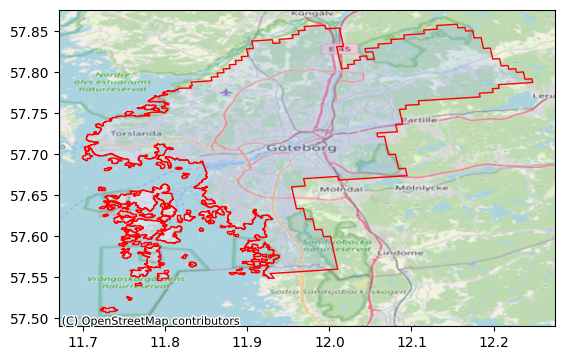

MultiPolygon


In [8]:
vizVectorGeom(INPUT)

In [9]:
len(shapely.get_rings(INPUT.geoms)) #.interiors

68

In [10]:
print(shapely.get_rings(INPUT.geoms[0])) #.interiors

[<LINEARRING (12.094 57.678, 12.095 57.674, 12.086 57.673, 12.078 57.673, 12....>]


In [14]:
## CHECKING RINGS
# i = 0
# for polygon in INPUT.geoms:
#     print(len(list(INPUT.geoms[i].interiors)) > 0)
#     i = i +1

In [15]:
qAGGREGATE= 'select avg_cells(clip((m[145, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT)) + ')) from Surface_Temperature_Sweden as m'
query2numeric(qAGGREGATE)

None: MultiPolygon is processing


15.929312977099277

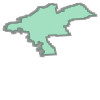

In [15]:
INPUT.geoms[0]

In [16]:
type(INPUT.geoms[0])

shapely.geometry.polygon.Polygon

In [17]:
print(INPUT.geoms[0].area)

0.06667194893089402


In [18]:
'{:.70f}'.format(2.577740087866099e-05)

'0.0000257774008786609896796970797794301688554696738719940185546875000000'

In [19]:
'{:.20f}'.format(INPUT.geoms[15].area)

'0.00006499548180712245'

In [60]:
## CHECKING AREAS
i = 0
poly_area = []
for polygon in INPUT.geoms:
    print(f"{INPUT.geoms[i].area}\t\t\t\t{'{:.10f}'.format(INPUT.geoms[i].area)}")
    poly_area.append(INPUT.geoms[i].area)
    i = i +1

0.06667194893089402				0.0666719489
6.170933920578587e-05				0.0000617093
9.260038495758423e-06				0.0000092600
1.7756679881445614e-05				0.0000177567
3.270123124750129e-05				0.0000327012
5.431998943063442e-05				0.0000543200
5.493426942816974e-05				0.0000549343
4.1355746362006784e-05				0.0000413557
1.836975206902377e-05				0.0000183698
1.2659505954633592e-05				0.0000126595
8.341798092973172e-06				0.0000083418
1.5889574570214645e-05				0.0000158896
0.0011264173390340302				0.0011264173
2.5313453079671064e-05				0.0000253135
1.2959495506994806e-05				0.0000129595
6.499548180712245e-05				0.0000649955
2.577740087866099e-05				0.0000257774
0.00015199274275800394				0.0001519927
3.04061031782837e-05				0.0000304061
9.71975168741608e-06				0.0000097198
1.1258507583435725e-05				0.0000112585
7.778332474046599e-05				0.0000777833
0.00010541218580319427				0.0001054122
1.4353478036055662e-05				0.0000143535
1.697311381538717e-05				0.0000169731
0.00010077500155518515				0.0001007750
7.414

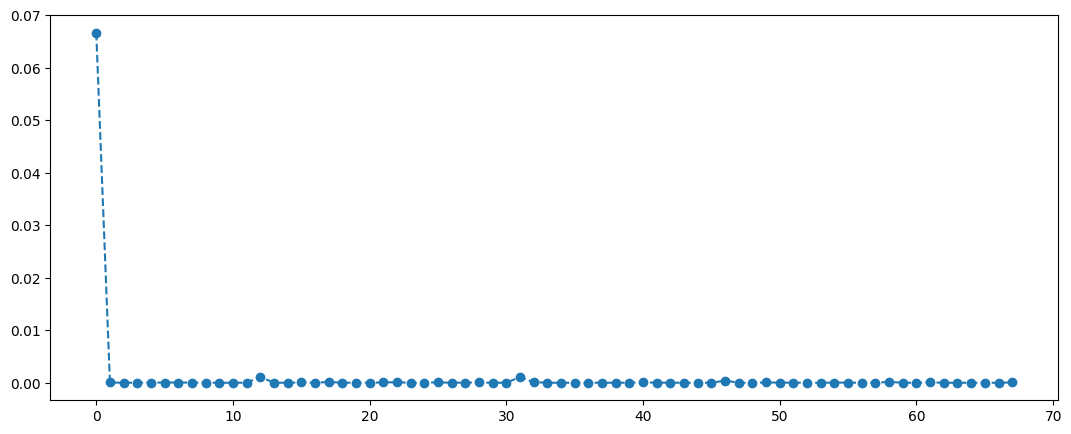

In [61]:
fig = plt.figure(figsize=(13, 5))
plt.plot(poly_area, '--',marker='o', )

In [30]:
np.max(poly_area)

0.06667194893089402

## Umeå

Umeå


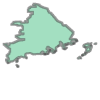

In [278]:
gid = 214 #246, 9, 150 || 214 (Umeå)
print(gdfSWE.NAME_2[gid])
INPUT = gdfSWE.geometry[gid]
INPUT

In [279]:
len(list(INPUT.geoms[0].interiors))

1

In [32]:
## CHECKING AREAS
i = 0
poly_area = []
for polygon in INPUT.geoms:
#     print(f"{INPUT.geoms[i].area}\t\t\t\t{'{:.10f}'.format(INPUT.geoms[i].area)}")
    poly_area.append(INPUT.geoms[i].area)
    i = i +1

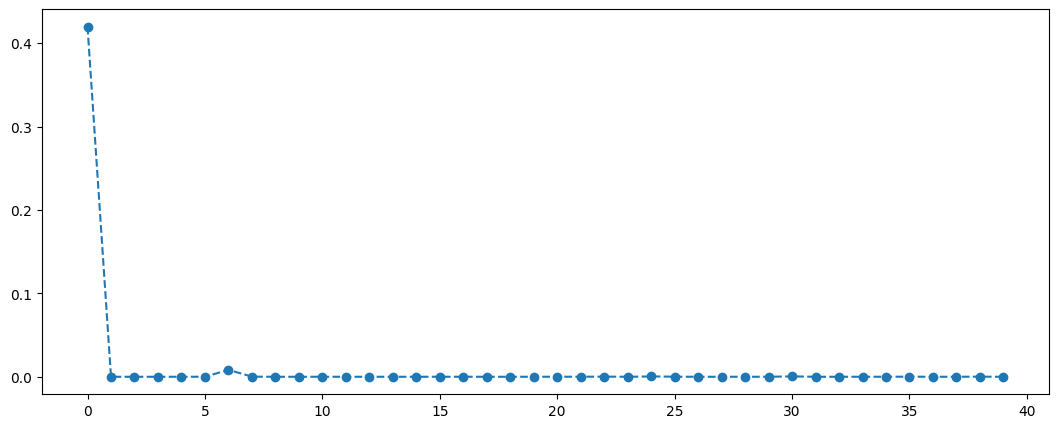

In [58]:
fig = plt.figure(figsize=(13, 5))
plt.plot(poly_area, '--',marker='o', )

In [34]:
np.max(poly_area)

0.41969216529105713

## ALL


In [174]:
gids = []
states = []
geommax = []
for gid in range(0, len(gdfSWE)):
    states.append(gdfSWE.NAME_2[gid])
    gids.append(gid)
    i = 0
    poly_area = []
    INPUT = gdfSWE.geometry[gid]
    if INPUT.geom_type == 'MultiPolygon':
        for polygon in INPUT.geoms:
            poly_area.append(INPUT.geoms[i].area)
            i = i +1
    else: 
        poly_area = INPUT.area
    geommax.append(np.max(poly_area))

In [175]:
len(states)

286

In [176]:
INPUT.geom_type

'Polygon'

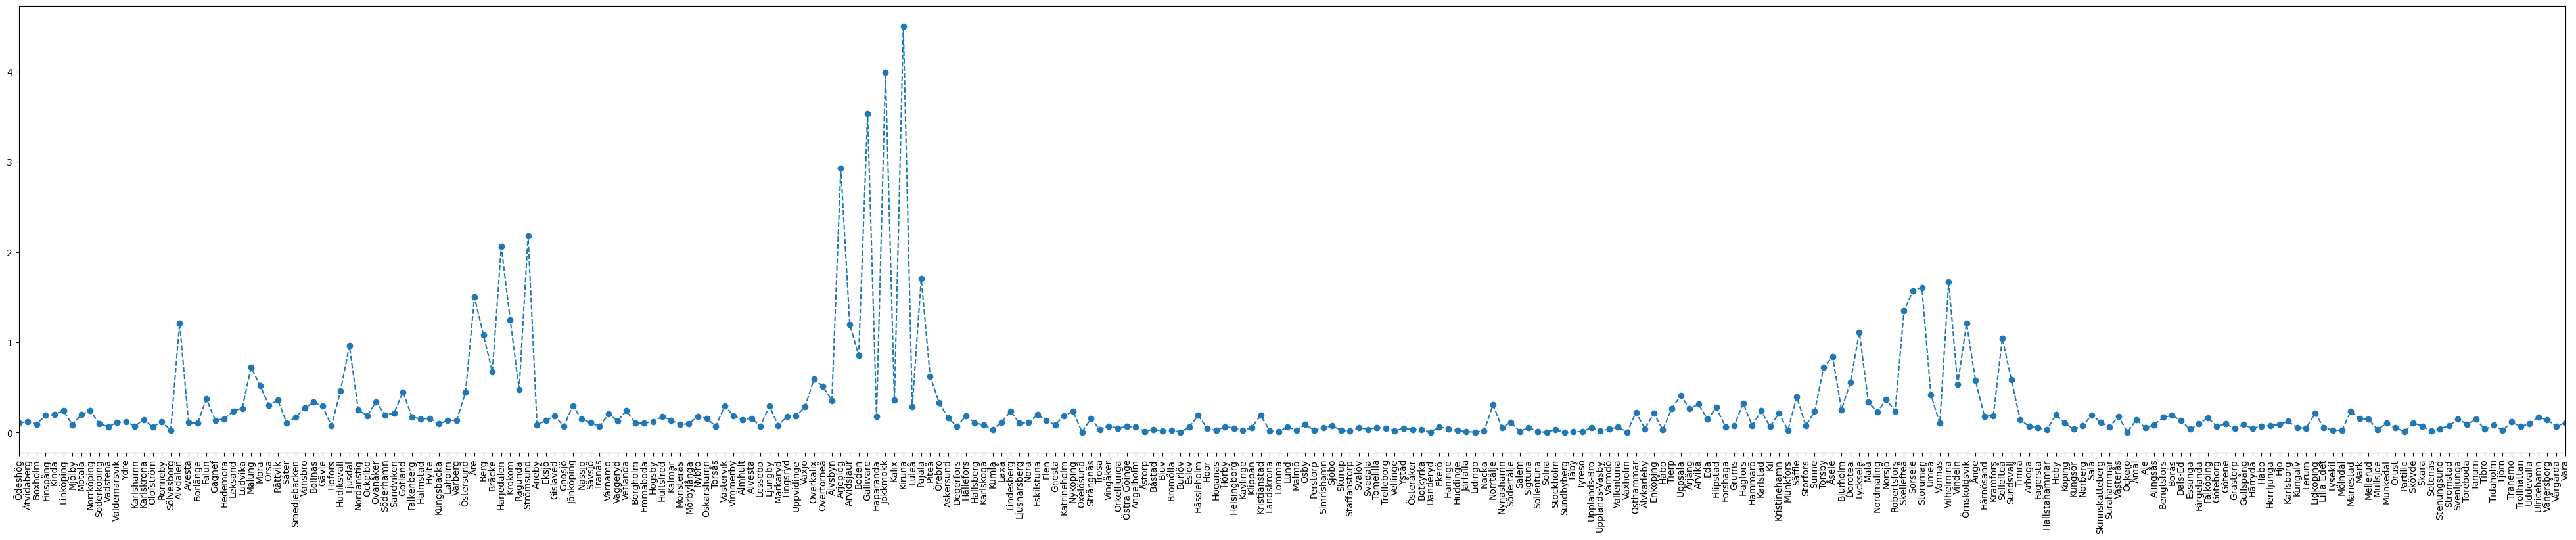

In [178]:
fig = plt.figure(figsize=(50, 10))
fig.autofmt_xdate(rotation=90)
plt.plot(states, geommax, '--',marker='o')
plt.xticks(rotation='vertical')
plt.margins(x=0)
plt.show()

In [139]:
len(geommax)

286

In [146]:
geommax

[0.10354472346444092,
 0.12095052922451176,
 0.09312369172402861,
 0.18908232979083575,
 0.19881844120573045,
 0.24210429398953814,
 0.08538052724543987,
 0.19680443076867665,
 0.24173852448074437,
 0.09872348762292656,
 0.06444355261010903,
 0.10982472951582233,
 0.11789013927773506,
 0.07060209436167962,
 0.14427750273900392,
 0.05997510397719888,
 0.12040327304201878,
 0.025251903736713346,
 1.213768144158168,
 0.10876713087418001,
 0.10260454067428863,
 0.37214772249899747,
 0.13256254437146284,
 0.15180376986971844,
 0.2381701016165479,
 0.2683055534398687,
 0.7210224149803268,
 0.5190366533679396,
 0.3025150257926797,
 0.35683229831921015,
 0.10330078152218929,
 0.17067251364460131,
 0.2710029276058882,
 0.3341037527516249,
 0.291009138985828,
 0.07304900210874345,
 0.4599043471062168,
 0.9602411980831562,
 0.24681597087692403,
 0.18796531235784153,
 0.34027034754035396,
 0.19277389843773798,
 0.2136140256661871,
 0.4501904729149925,
 0.17170162617002788,
 0.1503193780336092,
 0.

In [163]:
gids = []
states = []
geommax = []
for gid in range(0, len(gdfBAV)):
    states.append(gdfBAV.NAME_2[gid])
    gids.append(gid)
    i = 0
    poly_area = []
    INPUT = gdfBAV.geometry[gid]
    if INPUT.geom_type == 'MultiPolygon':
        for polygon in INPUT.geoms:
            poly_area.append(INPUT.geoms[i].area)
            i = i +1
    else: 
        poly_area = INPUT.area
    geommax.append(np.max(poly_area))

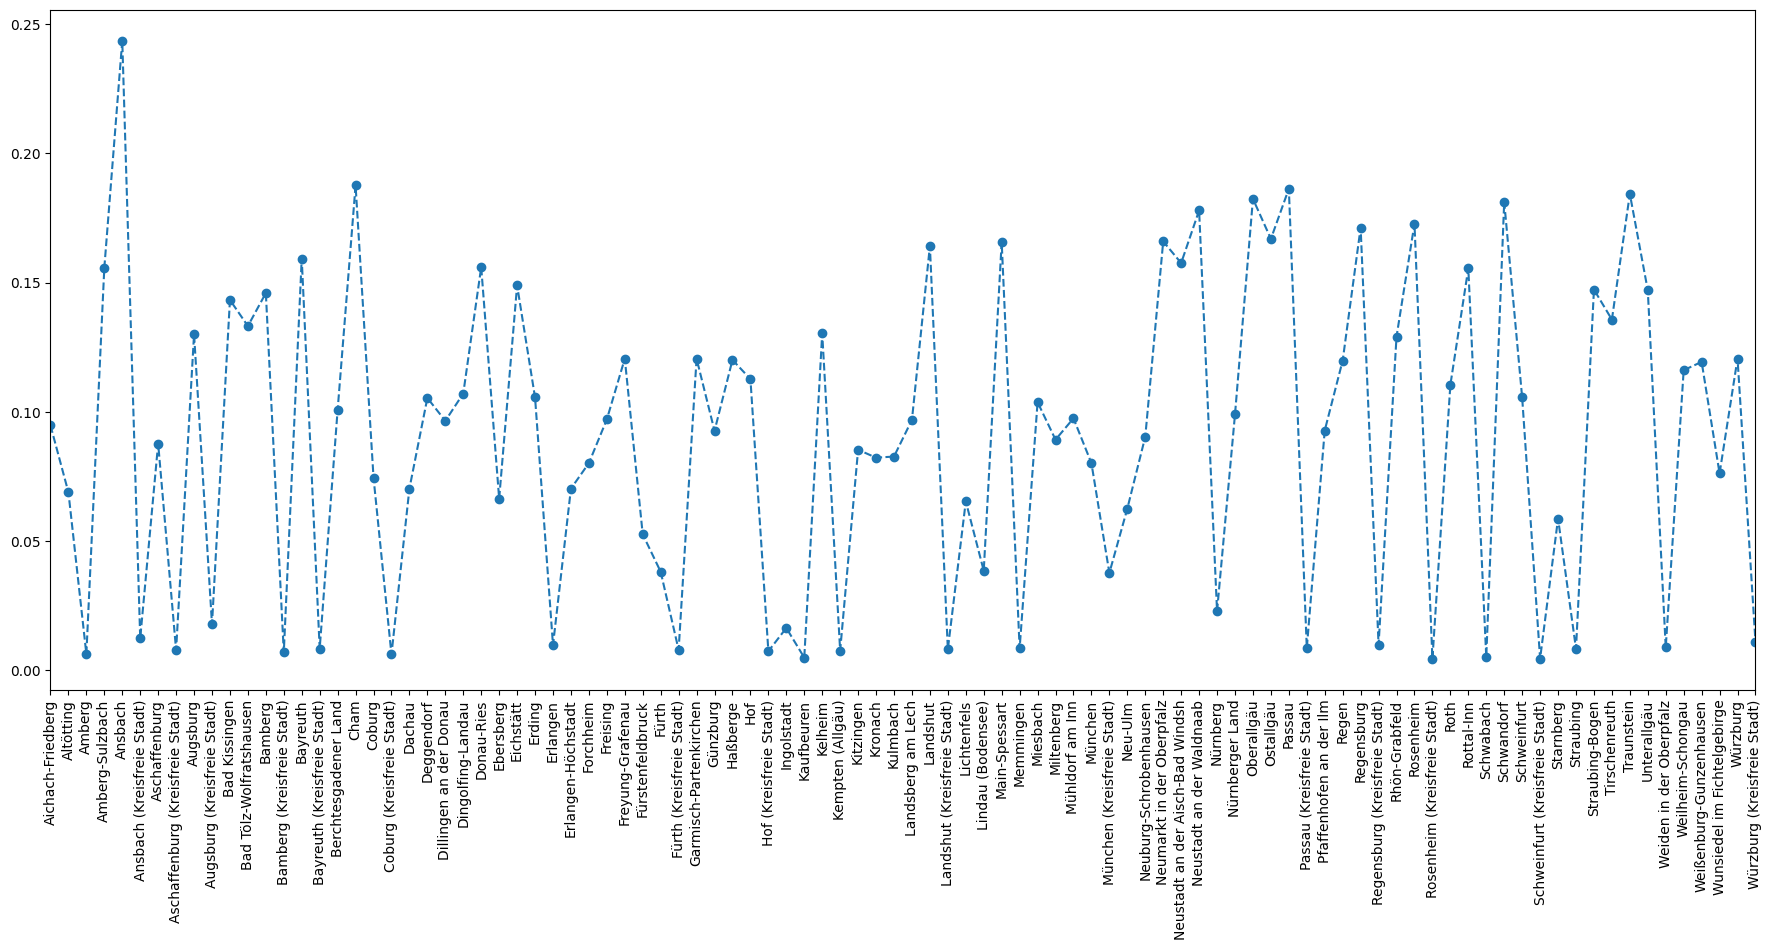

In [172]:
fig = plt.figure(figsize=(22, 10))
fig.autofmt_xdate(rotation=90)
plt.plot(states, geommax, '--',marker='o')
plt.xticks(rotation='vertical')
plt.margins(x=0)
plt.show()

In [217]:
for gid in range(0, len(gdfSWE)):
    INPUT = gdfSWE.geometry[gid]
    if INPUT.geom_type == 'MultiPolygon':
        print(f"{gid}\t{gdfSWE.NAME_2[gid]}\t\t\t\t\t{len(shapely.get_rings(INPUT.geoms))}")
    else: 
        print(f"{gid}\t{gdfSWE.NAME_2[gid]}\t\t\t\t\t{0}")

0	Ödeshög					3
1	Åtvidaberg					2
2	Boxholm					3
3	Finspång					0
4	Kinda					0
5	Linköping					0
6	Mjölby					0
7	Motala					0
8	Norrköping					88
9	Söderköping					133
10	Vadstena					0
11	Valdemarsvik					125
12	Ydre					0
13	Karlshamn					27
14	Karlskrona					61
15	Olofström					0
16	Ronneby					33
17	Sölvesborg					6
18	Älvdalen					0
19	Avesta					0
20	Borlänge					0
21	Falun					3
22	Gagnef					2
23	Hedemora					0
24	Leksand					3
25	Ludvika					0
26	Malung					0
27	Mora					0
28	Orsa					0
29	Rättvik					2
30	Säter					0
31	Smedjebacken					0
32	Vansbro					0
33	Bollnäs					0
34	Gävle					18
35	Hofors					0
36	Hudiksvall					30
37	Ljusdal					3
38	Nordanstig					6
39	Ockelbo					0
40	Ovanåker					0
41	Söderhamn					14
42	Sandviken					0
43	Gotland					34
44	Falkenberg					3
45	Halmstad					2
46	Hylte					2
47	Kungsbacka					40
48	Laholm					0
49	Varberg					18
50	Östersund					3
51	Åre					0
52	Berg					0
53	Bräcke					0
54	Härjedalen					0
55	Krokom					4
56	Ragunda					0
57

Linköping


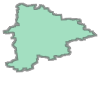

In [290]:
gid = 5	 #246, 9 || Highest MultiPolys 150, 79 || 214 (Umeå)
print(gdfSWE.NAME_2[gid])
INPUT = gdfSWE.geometry[gid]
INPUT

In [291]:
len(INPUT.interiors)

0

In [292]:
len(list(INPUT.geoms[0].interiors))

AttributeError: 'Polygon' object has no attribute 'geoms'

In [294]:
len(INPUT.interiors)

0

In [295]:
len(INPUT.exterior)

TypeError: object of type 'LinearRing' has no len()

Västervik


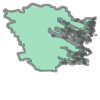

In [296]:
gid = 79	 #246, 9 || Highest MultiPolys 150, 79 || 214 (Umeå)
print(gdfSWE.NAME_2[gid])
INPUT = gdfSWE.geometry[gid]
INPUT

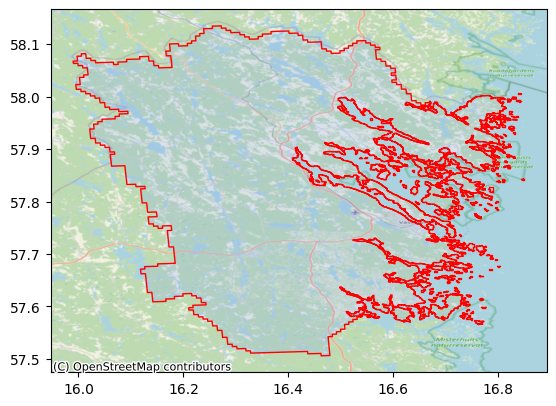

MultiPolygon


In [297]:
vizVectorGeom(INPUT)

In [298]:
len(list(INPUT.geoms[0].interiors))

0

In [313]:
for poly in list(INPUT.geoms):
    print(poly)

POLYGON ((16.46861076354992 57.83013916015625, 16.46861076354992 57.830417633056584, 16.469722747802848 57.830417633056584, 16.469722747802848 57.83094024658203, 16.469722747802848 57.831249237060604, 16.470277786254826 57.831249237060604, 16.470277786254826 57.83152770996094, 16.469722747802848 57.83152770996094, 16.469722747802848 57.83180618286133, 16.469167709350643 57.83180618286133, 16.469167709350643 57.83208465576172, 16.46861076354992 57.83208465576172, 16.46861076354992 57.83291625976568, 16.468055725097713 57.83291625976568, 16.468055725097713 57.83347320556646, 16.46861076354992 57.83347320556646, 16.46861076354992 57.834026336669865, 16.469167709350643 57.834026336669865, 16.469167709350643 57.83458328247082, 16.469722747802848 57.83458328247082, 16.469722747802848 57.83486175537121, 16.470277786254826 57.83486175537121, 16.470277786254826 57.8351402282716, 16.47083282470703 57.8351402282716, 16.47083282470703 57.835693359375, 16.471389770507812 57.835693359375, 16.4713897

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/rasdapy/cores/utils.py", line 447, in run
    self._target(*self._args)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/rasdapy/cores/remote_procedures.py", line 73, in rasmgr_keep_alive
    return stub.KeepAlive(make_rasmgr_keep_alive_req(cuuid), _TIMEOUT_SECONDS)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/grpc/_channel.py", line 946, in __call__
    return _end_unary_response_blocking(state, call, False, None)
  File "/home/arkaghosh/.local/lib/python3.8/site-packages/grpc/_channel.py", line 849, in _end_unary_response_blocking
    raise _InactiveRpcError(state)
grpc._channel._InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "NThe client with client ID 28 does not exist: cannot reset client's 

In [309]:
type(list(INPUT.geoms)[1])

shapely.geometry.polygon.Polygon

Norrtälje


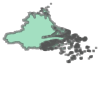

In [244]:
gid = 165	 #246, 9 || Highest MultiPolys 165, 79 || 214 (Umeå)
print(gdfSWE.NAME_2[gid])
INPUT = gdfSWE.geometry[gid]
INPUT

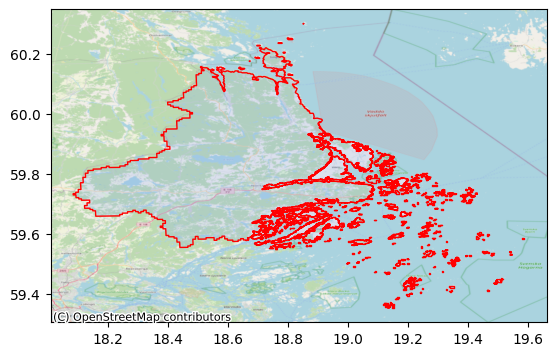

MultiPolygon


In [245]:
vizVectorGeom(INPUT)

In [252]:
str(geoPOLYGON_to_gridPOLYGON_03(INPUT))

None: MultiPolygon is processing


'MULTIPOLYGON (((1114 954, 1114 955, 1114 956, 1114 957, 1114 958, 1114 959, 1114 960, 1114 961, 1114 962, 1114 963, 1115 963, 1115 964, 1114 964, 1114 965, 1114 966, 1115 966, 1115 967, 1115 968, 1115 969, 1114 969, 1114 970, 1115 970, 1115 971, 1115 972, 1115 973, 1116 973, 1116 974, 1117 974, 1118 974, 1118 973, 1119 973, 1120 973, 1120 972, 1121 972, 1121 971, 1121 970, 1122 970, 1122 969, 1122 968, 1123 968, 1123 967, 1122 967, 1122 966, 1122 965, 1123 965, 1123 964, 1123 963, 1123 962, 1123 961, 1123 960, 1122 960, 1122 959, 1123 959, 1123 958, 1123 957, 1122 957, 1121 957, 1121 956, 1121 955, 1121 954, 1122 954, 1122 955, 1122 956, 1123 956, 1123 955, 1123 954, 1123 953, 1123 952, 1123 951, 1124 951, 1124 952, 1125 952, 1125 951, 1125 950, 1125 949, 1124 949, 1124 948, 1125 948, 1125 947, 1124 947, 1123 947, 1123 946, 1123 945, 1124 945, 1124 944, 1124 943, 1124 942, 1124 941, 1124 940, 1124 939, 1124 938, 1125 938, 1125 937, 1125 936, 1126 936, 1127 936, 1127 935, 1126 935, 112

## RasdaMan Query 

In [246]:
qAGGREGATE= 'select avg_cells(clip((m[145, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT)) + ')) from Surface_Temperature_Sweden as m'
query2numeric(qAGGREGATE)

None: MultiPolygon is processing


10.547337715694335

## PGSQL

In [247]:
import psycopg2

conn = psycopg2.connect(database="VectorDB",
                        host="localhost",
                        user="postgres",
                        password="bolbona",
                        port="5432")


In [248]:
cursor = conn.cursor()

In [249]:
cursor.execute("SELECT  name_2, ST_NumInteriorRings(geom), ST_AsText(geom) FROM region_sweden as m WHERE   m.name_2 = 'Göteborg'")

In [250]:
print(cursor.fetchone())

('Göteborg', None, 'MULTIPOLYGON(((12.093682289123535 57.67838287353521,12.094663619995174 57.6739234924317,12.086322784423828 57.67339324951172,12.077977180480957 57.67285919189459,12.069632530212402 57.6723251342774,12.061288833618164 57.67179107666027,12.052947044372672 57.67125320434576,12.044603347778434 57.67071914672863,12.036261558532715 57.67018127441412,12.027917861938477 57.66964721679693,12.019576072692985 57.66910934448242,12.011234283447322 57.66857147216791,12.010240554809627 57.67302703857422,12.001896858215389 57.67248916625971,11.993555068969727 57.671951293945426,11.985211372375431 57.67140960693371,11.97686958312994 57.6708717346192,11.968527793884277 57.670330047607536,11.969526290893612 57.66587066650402,11.970526695251579 57.66141510009771,11.96218490600586 57.660873413085994,11.95384597778326 57.66033172607433,11.954846382141227 57.655876159668026,11.955846786499137 57.65141677856451,11.956847190856877 57.6469612121582,11.957847595214844 57.64250564575207,11.958